In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates

plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
df = pd.read_csv('../data/ihe_testing_casecounts_fall2020.csv', dtype={'ipeds_id':str})
ll = pd.read_csv('../data/county_newcases_nyt.csv', dtype={'fips':str})
ipeds_df = pd.read_csv('../data/ipeds_data.csv', encoding='latin8', dtype={'ipeds_id':str,
                                                                           'Fips County code (HD2019)':str})

rename_ipeds = {'Institution Name':'name', 'Latitude location of institution (HD2019)':'lat',
                'Longitude location of institution (HD2019)':'lon', 'Level of Institution':'institution_level',
                'Control of institution':'institution_control', 'Institution Size':'institution_size_bin',
                'Total enrollment (DRVEF2018)':'enrollment_total','Fips County code (HD2019)':'fips',
                'Full-time enrollment (DRVEF2018)':'enrollment_fulltime', 
                'Endowment per FTE':'endowment_per_fte',
                'Percent admitted - total (DRVADM2019)':'percent_admitted'}

ipeds_df = ipeds_df.rename(columns=rename_ipeds)
ipeds_df = ipeds_df[['ipeds_id','fips', 'lat', 'lon', 'institution_level', 'institution_control',
                     'institution_size_bin', 'enrollment_total', 'enrollment_fulltime',
                     'endowment_per_fte', 'percent_admitted']]
ipeds_df['fips'] = ("0"+ipeds_df['fips'].str[:]).str[-5:]
df = df.merge(ipeds_df[['ipeds_id','fips','enrollment_fulltime','enrollment_total']], how='left', on='ipeds_id')

In [3]:
# get counties of schools that do / don't test frequently

In [4]:
ihe_df = df.groupby(['college','ipeds_id','fips',
                     'enrollment_fulltime','enrollment_total']).agg({'total_tests':'sum',
                                                                     'positive_tests':'sum'}).reset_index()

In [5]:
cumul_only = df.loc[~df['notes'].isna()].reset_index().iloc[:,1:].copy()
cumul_tests = cumul_only.loc[cumul_only['notes'].str.contains('cumulative_tests')].reset_index().iloc[:,1:].copy()
cumul_cases = cumul_only.loc[cumul_only['notes'].str.contains('cumulative_cases')].reset_index().iloc[:,1:].copy()
cumul_cases['positive_tests'] = [int(i[1]) for i in cumul_cases['notes'].str.split('cumulative_cases = ')]
cumul_tests['total_tests'] = [int(i[1]) for i in cumul_tests['notes'].str.split('cumulative_tests = ')]
# cumul_ipeds = np.unique(cumul_cases['ipeds_id'].to_list())
df_temp = df.copy()
df_temp['gran'] = df_temp['total_tests'] + df_temp['positive_tests']
df_temp = df_temp.groupby(['college','ipeds_id']).agg({'gran':'sum'}).reset_index()
cumul_ipeds = df_temp.loc[df_temp['gran']<=0]['ipeds_id'].values
# cumul_ipeds = np.unique(cumul_tests['ipeds_id'].to_list() + cumul_cases['ipeds_id'].to_list())

In [6]:
times_df = ihe_df.loc[~ihe_df['ipeds_id'].isin(cumul_ipeds)].reset_index().iloc[:,1:].copy()
cumul_df = df.loc[df['ipeds_id'].isin(cumul_ipeds)][['college', 'ipeds_id', 'fips',
                  'enrollment_fulltime','enrollment_total']].drop_duplicates().reset_index().iloc[:,1:].copy()
cumul_df = cumul_df.merge(cumul_tests[['ipeds_id','total_tests']],how='left',on='ipeds_id')
cumul_df = cumul_df.merge(cumul_cases[['ipeds_id','positive_tests']],how='left',on='ipeds_id')

dfw = pd.concat([times_df,cumul_df]).reset_index().iloc[:,1:].copy()
dfw['total_tests'] = np.nan_to_num(dfw['total_tests'])

In [7]:
dfw['total_tests_per_1000_fulltime'] = (dfw['total_tests']/dfw['enrollment_fulltime']) * 1000
dfw['total_tests_per_1000_enrollment'] = (dfw['total_tests']/dfw['enrollment_total']) * 1000
dfw['positive_tests_per_1000_fulltime'] = (dfw['positive_tests']/dfw['enrollment_fulltime']) * 1000
dfw['positive_tests_per_1000_enrollment'] = (dfw['positive_tests']/dfw['enrollment_total']) * 1000

In [8]:
min_tests = 1000
var = 'total_tests'
nontest_fips = list(dfw.loc[dfw[var]<=min_tests]['fips'].unique())
yestest_fips = list(dfw.loc[dfw[var]>min_tests]['fips'].unique())
nontest_fips = [i for i in nontest_fips if i not in yestest_fips]

ll_non = ll.loc[ll['fips'].isin(nontest_fips)].reset_index().iloc[:,1:].copy()
ll_yes = ll.loc[ll['fips'].isin(yestest_fips)].reset_index().iloc[:,1:].copy()

ll_non = ll_non.loc[(ll_non['date']>'2020-06-30')&(ll_non['date']<'2020-12-20')].copy()
ll_yes = ll_yes.loc[(ll_yes['date']>'2020-06-30')&(ll_yes['date']<'2020-12-20')].copy()

In [ ]:
regions_dict = {'Plains':['Iowa', 'Kansas', 'Minnesota', 'Missouri',
                          'Nebraska', 'North Dakota', 'South Dakota'],
                'Rocky Mountains':['Colorado', 'Idaho', 'Montana', 'Utah', 'Wyoming'],
                'Far West':['Alaska', 'California', 'Hawaii', 'Nevada', 'Oregon', 'Washington'],
                'Southwest':['Arizona', 'New Mexico', 'Oklahoma', 'Texas'],
                'Great Lakes':['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin'],
                'Southeast':['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Kentucky', 'Louisiana',
                             'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee',
                             'Virginia', 'West Virginia'],
                'New England':['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
                               'Rhode Island', 'Vermont'],
                'Mid East':['Delaware', 'District of Columbia', 'Maryland', 'New Jersey',
                            'New York', 'Pennsylvania']}

reg_names = [[list(regions_dict.keys())[i]]*len(list(regions_dict.values())[i]) for i in range(len(regions_dict))]
reg_state = list(regions_dict.values())

flat_names = [item for sublist in reg_names for item in sublist]
flat_state = [item for sublist in reg_state for item in sublist]
region_df = pd.DataFrame({'region':flat_names,'state':flat_state})

df = df.merge(region_df, how='left', on='state')
ll = ll.merge(region_df, how='left', on='state')

In [9]:
def get_ci(df, col, gb_col='date', percentile='95'):
    if percentile == '95':
        cival = 1.96

    df_stats = df.groupby(gb_col)[col].agg([np.nanmean,'count',np.nanstd])
    ci95_hi = []
    ci95_lo = []
    for i in df_stats.index:
        m, c, s = df_stats.loc[i]
        ci95_hi.append(m + cival*s/np.sqrt(c))
        ci95_lo.append(m - cival*s/np.sqrt(c))
    df_stats['ci95_hi'] = ci95_hi
    df_stats['ci95_lo'] = ci95_lo

    return df_stats

In [14]:
dfr = df.groupby(['date','region']).agg({'positive_tests':'sum',
                                         'enrollment_fulltime':'sum',
                                         'ipeds_id':'count'}).reset_index()
dfr['positive_tests_per_1000'] = (dfr['positive_tests'] / dfr['enrollment_fulltime']) * 1000

In [15]:
llr = ll.groupby(['date','region']).agg({'new_cases_county':'sum',
                                         'county_population':'sum',
                                         'fips':'count'}).reset_index()
llr['new_cases_county_per_1000'] = (llr['new_cases_county'] / llr['county_population']) * 1000
llr = llr.loc[(llr.date>'2020-07-31')&(llr.date<'2020-12-17')].copy()

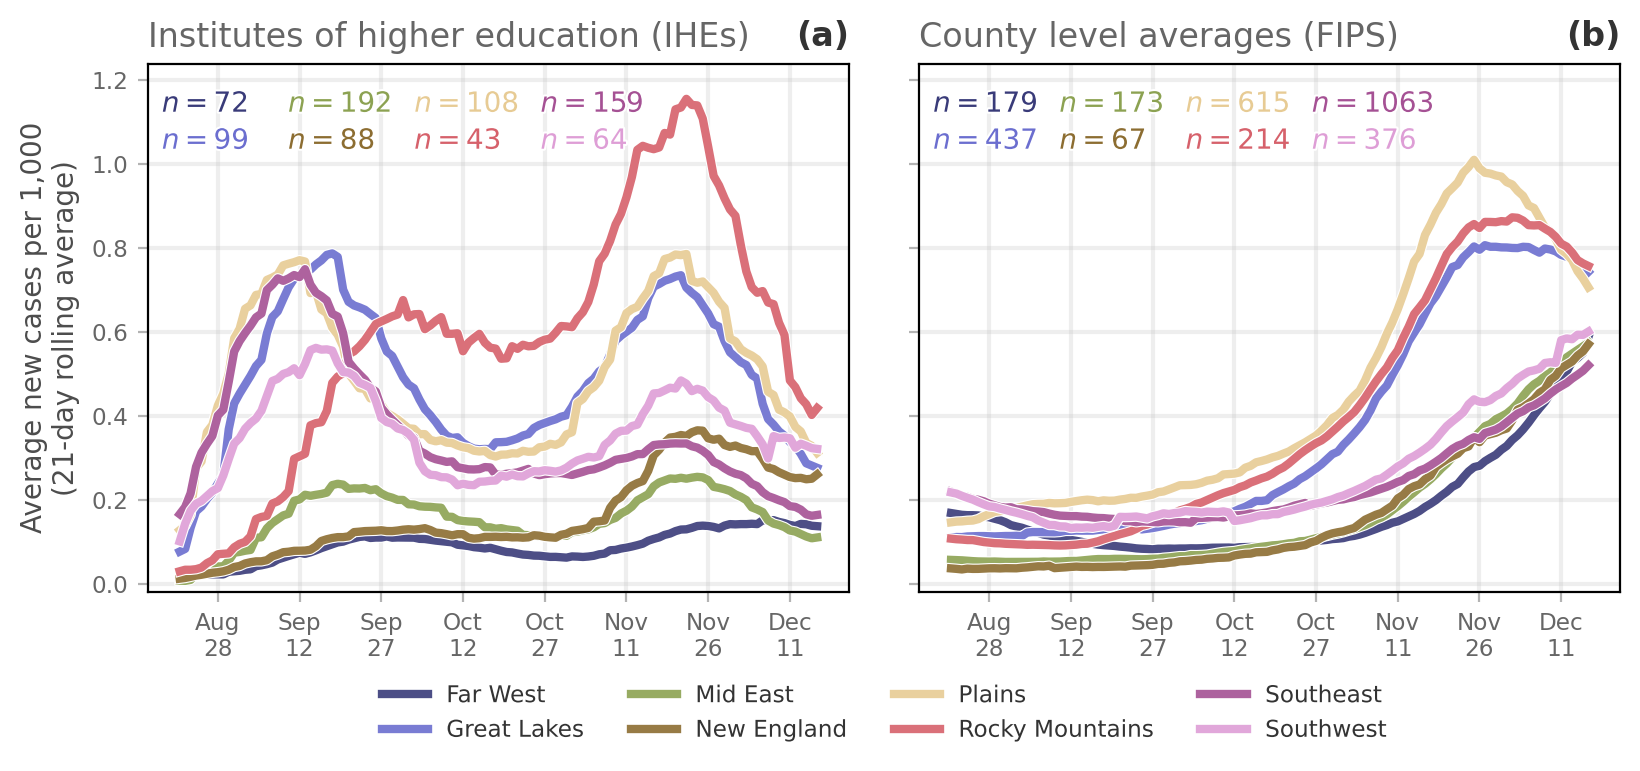

In [16]:
wid = 21

fig, ax = plt.subplots(1,2,figsize=(9.5,3.5),dpi=200,sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.1)
cols = plt.cm.tab20b(np.linspace(0,1,dfr.region.nunique()))

ycurr = 0.95
xcurr = 0.02

for ri,r in enumerate(dfr.region.unique()):
    dfr_i = dfr.loc[dfr['region']==r].copy()
    llr_i = llr.loc[llr['region']==r].copy()
    x_dfr = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in dfr_i['date'].values]
    x_llr = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in llr_i['date'].values]
    ax[0].plot(x_dfr, dfr_i['positive_tests_per_1000'].rolling(window=wid).mean().values,
             color='w',lw=3.8)
    ax[0].plot(x_dfr, dfr_i['positive_tests_per_1000'].rolling(window=wid).mean().values,
             color=cols[ri],label=r,lw=3,alpha=0.9)
    ax[1].plot(x_llr, llr_i['new_cases_county_per_1000'].rolling(window=wid).mean().values,
             color='w',lw=3.8)
    ax[1].plot(x_llr, llr_i['new_cases_county_per_1000'].rolling(window=wid).mean().values,
             color=cols[ri],lw=3,alpha=0.9)
    ax[0].text(xcurr, ycurr, "$n=%i$"%int(np.mean(dfr_i['ipeds_id'])), ha='left', va='top',
               transform=ax[0].transAxes, color=cols[ri],
               path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),path_effects.Normal()])
    ax[1].text(xcurr, ycurr, "$n=%i$"%int(np.mean(llr_i['fips'])), ha='left', va='top',
               transform=ax[1].transAxes, color=cols[ri],
               path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),path_effects.Normal()])
    ycurr -= 0.07
    if ri % 2 != 0:
        ycurr = 0.95
        xcurr += 0.18

ax[0].set_ylabel('Average new cases per 1,000\n(%i-day rolling average)'%(wid), color='.3')
ax[0].set_title('Institutes of higher education (IHEs)', color='.4',x=0,ha='left',fontsize='large')
ax[1].set_title('County level averages (FIPS)', color='.4',x=0,ha='left',fontsize='large')
l = ax[0].legend(ncol=4,framealpha=0.0,fontsize='small',bbox_to_anchor=[1.05,-0.135],loc=9)
for text in l.get_texts():
    text.set_color('.2')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

letts = ["(a)","(b)"]
for ai, a in enumerate(fig.axes):
    a.set_xticks(x_llr[27::15])
    a.set_xticklabels(["{:%b\n%d}".format(i) for i in x_llr[27::15]],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7',labelsize='small')
    a.set_ylim(-0.02,1.24)
    a.text(1.0, 1.02, letts[ai], ha='right', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize='large', color='.2')

    
plt.savefig('../figs/pngs/cases_IHE_FIPS_regions.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/cases_IHE_FIPS_regions.pdf',bbox_inches='tight')

plt.show()